In [215]:
import numpy as np
import wandb

In [216]:
import numpy as np
import wandb

''' MLP class  '''
class MLP:
    ''' Multi-layer perceptron class '''
    ''' input_size, hidden_layers = [sizes of the hidden layers], output_size, epochs, learning_rate, batch_size, activation_function, loss_function '''
    def __init__(self, input_size, hidden_layers, output_size, epochs = 100, learning_rate = 0.01, early_stopping = False,
                 batch_size = 32, activation_function = 'relu', loss_function = 'mse', optimizer = 'sgd', beta = 0.0, 
                 Random_state = None, weight_init = 'he', model_type = 'class_ML', wandb_vaar = False, run_start = "hyperparam_tuning", wandb_finish = True):
        
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation_function = activation_function
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.early_stopping = early_stopping
        self.beta = beta
        self.weight_init = weight_init
        self.model_type = model_type
        self.wandb_vaar = wandb_vaar
        self.wandb_finish = wandb_finish
        
        self.weights = []
        self.biases = []
        self.loss = []
        self.history = []
        
        np.random.seed(Random_state)
        
        self._initialize_weights()
        
        run_name = f"{run_start}-{self.activation_function}-{self.optimizer}-{self.loss_function}-{self.weight_init}-{self.epochs}-{self.learning_rate}-{self.batch_size}"
        
        # Initialize WandB
        if wandb_vaar:
            wandb.init(
                project="SMAI_A3-MLP", 
                name=run_name,
                config={
                "learning_rate": self.learning_rate,
                "epochs": self.epochs,
                "batch_size": self.batch_size,
                "activation": self.activation_function,
                "optimizer": self.optimizer,
                "input_size": self.input_size,
                "hidden_layer_sizes": self.hidden_layers,
                "output_size": self.output_size,
                "loss_function": self.loss_function,
                "weight_init": self.weight_init,
                "Random_state": Random_state,
                "beta": self.beta,
                "early_stopping": self.early_stopping,
            })
        
    def _initialize_weights(self):
        ''' Initialize weights '''
        layers = [self.input_size] + self.hidden_layers + [self.output_size]
        for i in range(len(layers) - 1):
            if self.weight_init == 'random':
                self.weights.append(np.random.randn(layers[i], layers[i+1]))  # Random initialization
            
            elif self.weight_init == 'he':
                self.weights.append(np.random.randn(layers[i], layers[i+1]) * np.sqrt(2. / layers[i]))  # He initialization
            
            elif self.weight_init == 'xavier':
                limit = np.sqrt(6 / (layers[i] + layers[i+1]))
                self.weights.append(np.random.uniform(-limit, limit, (layers[i], layers[i+1])))  # Xavier/Glorot initialization
            
            self.biases.append(np.zeros(layers[i+1]))
        
        self.vW = [np.zeros_like(w) for w in self.weights]  # Initialize velocity for weights
        self.vb = [np.zeros_like(b) for b in self.biases]   # Initialize velocity for biases
    
    # Activation functions       
    def relu(self, x):
        ''' ReLU activation function '''
        return np.where(x > 0, x, x * 0.01)
    def relu_derivative(self, x):
        ''' ReLU derivative '''
        return np.where(x > 0, 1, 0.01)
    
    def sigmoid(self, x):
        ''' Sigmoid activation function '''
        return 1 / (1 + np.exp(-x))
    def sigmoid_derivative(self, x):
        ''' Sigmoid derivative '''
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def tanh(self, x):
        ''' Tanh activation function '''
        return np.tanh(x)
    def tanh_derivative(self, x):
        ''' Tanh derivative '''
        return 1 - np.tanh(x)**2
    
    def linear(self, x):
        ''' Linear activation function '''
        return x
    def linear_derivative(self, x):
        ''' Linear derivative '''
        return 1
            
    def _activation(self, activation_function = None):
        ''' Activation function '''
        if activation_function == 'relu':
            return self.relu, self.relu_derivative
        elif activation_function == 'sigmoid':
            return self.sigmoid, self.sigmoid_derivative
        elif activation_function == 'tanh':
            return self.tanh, self.tanh_derivative
        elif activation_function == 'linear':
            return self.linear, self.linear_derivative
        else:
            raise ValueError('Activation function not supported')
    
    # Optimizers
    def mse(self, y, y_pred):
        ''' Mean squared error '''
        return np.mean((y - y_pred)**2)
    def mse_derivative(self, y, y_pred):
        ''' Mean squared error derivative '''
        return 2*(y_pred - y)
    
    # Loss for regression
    def rmse(self, y, y_pred):
        ''' Root mean squared error '''
        return np.sqrt(np.mean((y - y_pred)**2))
    def mae(self, y, y_pred):
        ''' Mean absolute error '''
        return np.mean(np.abs(y - y_pred))
    def r_squared(self, y, y_pred):
        ''' R-squared metric '''
        ss_res = np.sum((y - y_pred)**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        return 1 - (ss_res / ss_tot)
    
    def cross_entropy(self, y, y_pred):
        ''' Cross entropy loss '''
        return -np.sum(y * np.log(y_pred)) / len(y)
    
    def cross_entropy_derivative(self, y, y_pred):
        ''' Cross entropy derivative '''
        return (y_pred - y) # / (y_pred * (1 - y_pred) + 1e-6)  
    
    def _loss(self):
        ''' Loss function '''
        if self.loss_function == 'mse':
            return self.mse, self.mse_derivative
        elif self.loss_function == 'cross_entropy':
            return self.cross_entropy, self.cross_entropy_derivative
        else:
            raise ValueError('Loss function not supported')
        
    def _softmax(self, x):
        ''' Softmax activation function '''
        exps = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def _one_hot(self, y):
        ''' One-hot encoding '''
        print(y.min(), y.max())
        one_hot = np.zeros((y.size, y.max()+1- y.min()))
        for i in range(y.size):
            one_hot[i, y[i] - y.min()] = 1
        return one_hot
    
    def filter_onehot(self, y_true, y_test):
        y_true = np.argmax(y_true, axis=1)
        y_test = np.argmax(y_test, axis=1)
        return y_true, y_test
    
    def filter_softmax(self, y_pred):
        # if >0.5, then 1 else 0
        return np.where(y_pred > 0.5, 1, 0)
        
    
    def accuracy(self, y_true, y_pred):
        correct_predictions = np.sum(y_true == y_pred)
        total_predictions = len(y_true)
        return correct_predictions / total_predictions
    
    def hamming_loss(self, y_true, y_pred):
        # Compute the number of incorrectly predicted labels
        incorrect_labels = np.sum(y_true != y_pred)
        
        # Total number of labels is the number of samples times the number of labels per sample
        total_labels = y_true.shape[0] * y_true.shape[1]
        
        # Hamming Loss: Proportion of incorrect labels
        return incorrect_labels / total_labels
    
    def multi_label_partial_accuracy(self, y_true, y_pred):
        y_pred_partial = y_pred.reshape(-1, 1)
        y_true_partial = y_true.reshape(-1, 1)
        partial_accuracy = self.accuracy(y_true_partial, y_pred_partial)
        return partial_accuracy
    
    def multi_label_accuracy(self, y_true, y_pred):
        # Exact match accuracy (where all labels for a sample are correctly predicted)
        correct_predictions = np.sum(np.all(y_true == y_pred, axis=1))
        total_predictions = len(y_true)
        return correct_predictions / total_predictions
    
    def multi_label_confusion_matrix(self, y_true, y_pred):
        num_labels = y_true.shape[1]
        confusion_matrices = []

        for i in range(num_labels):
            tp = np.sum((y_pred[:, i] == 1) & (y_true[:, i] == 1))  # True Positive
            tn = np.sum((y_pred[:, i] == 0) & (y_true[:, i] == 0))  # True Negative
            fp = np.sum((y_pred[:, i] == 1) & (y_true[:, i] == 0))  # False Positive
            fn = np.sum((y_pred[:, i] == 0) & (y_true[:, i] == 1))  # False Negative

            matrix = np.array([[tn, fp], [fn, tp]])
            confusion_matrices.append(matrix)

        return np.array(confusion_matrices)
    
    def multi_label_micro_metrics_partial(self, y_true, y_pred):
        # confusion matrix
        confusion_matrix = self.multi_label_confusion_matrix(y_true, y_pred)

        # micro-averaged precision, recall, f1_score
        micro_precision = np.sum(confusion_matrix[:, 0, 0]) / np.sum(confusion_matrix[:, 0, 0] + np.sum(confusion_matrix[:, 1, 0] + 1e-6))
        micro_recall = np.sum(confusion_matrix[:, 0, 0]) / np.sum(confusion_matrix[:, 0, 0] + np.sum(confusion_matrix[:, 1, 1] + 1e-6))
        micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)
        
        return micro_precision, micro_recall, micro_f1_score
    
    def multi_label_macro_metrics_partial(self, y_true, y_pred):
        # confusion matrix
        confusion_matrix = self.multi_label_confusion_matrix(y_true, y_pred)

        # macro-averaged precision, recall, f1_score
        macro_precision = np.mean(confusion_matrix[:, 0, 0] / (confusion_matrix[:, 0, 0] + confusion_matrix[:, 1, 0] + 1e-6))
        macro_recall = np.mean(confusion_matrix[:, 0, 0] / (confusion_matrix[:, 0, 0] + confusion_matrix[:, 1, 1] + 1e-6))
        macro_f1_score = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall)
        
        return macro_precision, macro_recall, macro_f1_score
    
    def multi_label_precision_recall_f1(self, y_true, y_pred):
        epsilon = 1e-9  # To avoid division by zero

        # True Positives, False Positives, and False Negatives for each label
        true_positives = np.sum((y_pred == 1) & (y_true == 1), axis=0)
        false_positives = np.sum((y_pred == 1) & (y_true == 0), axis=0)
        false_negatives = np.sum((y_pred == 0) & (y_true == 1), axis=0)

        # Precision: TP / (TP + FP)
        precision = true_positives / (true_positives + false_positives + epsilon)
        
        # Recall: TP / (TP + FN)
        recall = true_positives / (true_positives + false_negatives + epsilon)
        
        # F1-Score: 2 * (Precision * Recall) / (Precision + Recall)
        f1 = 2 * (precision * recall) / (precision + recall + epsilon)

        # Return macro-average (mean over all labels)
        return precision, recall, f1
    
    def confusion_matrix(self, y_true, y_pred):
        classes = np.unique(y_true)
        matrix = np.zeros((len(classes), len(classes)), dtype=int)

        for i in range(len(y_true)):
            true_idx = np.where(classes == y_true[i])[0][0]
            pred_idx = np.where(classes == y_pred[i])[0][0]
            matrix[true_idx, pred_idx] += 1
        
        return matrix
    
    def recall(self, y_true, y_pred):
        matrix = self.confusion_matrix(y_true, y_pred)
        recall_values = np.diag(matrix) / np.sum(matrix, axis=1)  # TP / (TP + FN)
        recall_values = np.nan_to_num(recall_values)  # Handle division by zero
        return np.mean(recall_values)
    
    def precision(self, y_true, y_pred):
        matrix = self.confusion_matrix(y_true, y_pred)
        precision_values = np.diag(matrix) / np.sum(matrix, axis=0)  # TP / (TP + FP)
        precision_values = np.nan_to_num(precision_values)  # Handle division by zero
        return np.mean(precision_values)
    
    def f1_score(self, y_true, y_pred):
        prec = self.precision(y_true, y_pred)
        rec = self.recall(y_true, y_pred)
        if (prec + rec) == 0:
            return 0
        return 2 * (prec * rec) / (prec + rec)
    
    def model_functions(self):
        if self.model_type == 'class_ML':
            return self.sigmoid, self.sigmoid_derivative
        elif self.model_type == 'class_MC':
            return self._softmax, self.cross_entropy_derivative
        elif self.model_type == 'regression':
            return self._activation(self.activation_function)
    
    # Forward pass
    def forward(self, X, latent_space = False):
        ''' Forward pass '''
        activations = [X]
        Z = [X]
        
        activation, _ = self._activation(self.activation_function)
        current_activation = X
        
        # Hidden layers
        for i in range(len(self.weights) - 1):
            z = np.dot(current_activation, self.weights[i]) + self.biases[i]
            Z.append(z)
            current_activation = activation(z)
            activations.append(current_activation)
            
        # Output layer
        z = np.dot(current_activation, self.weights[-1]) + self.biases[-1]
        Z.append(z)
        
        # Check if the model is for classification or regression
        activation_function, _ = self.model_functions()
        # output_activation = self.relu(z) # Output activation function
        output_activation = activation_function(z) # Output activation function
        activations.append(output_activation)
        self.activations = activations
        
        return Z, activations
    
    # Backward pass
    def backward(self, X, y, Z, activations):
        ''' Backward pass '''
        grads = {}
        m = y.shape[0]
        
        # Activation function
        # activation_function, activation_derivative = self._activation(self.activation_function)
        activation_function, activation_derivative = self.model_functions()
        
        # Loss function
        # loss, loss_derivative = self._loss()
        if self.model_type == 'class_ML':
            loss, loss_derivative = self.cross_entropy, self.cross_entropy_derivative
        elif self.model_type == 'class_MC':
            loss, loss_derivative = self.cross_entropy, self.cross_entropy_derivative
        elif self.model_type == 'regression':
            loss, loss_derivative = self.mse, self.mse_derivative
        
        # backprop loss in output layer
        dA = loss_derivative(y, (activations[-1]))
        if self.model_type == 'class_MC':
            dZ = (activations[-1] - y) / m
        else:
            dZ = dA * activation_derivative(Z[-1])
        
        grads["dW" + str(len(self.weights)-1)] = np.dot(activations[-2].T, dZ) / m
        grads["db" + str(len(self.weights)-1)] = np.sum(dZ, axis=0) / m
        self.dZ = dZ
        
        # backprop hidden layers
        activation_function, activation_derivative = self._activation(self.activation_function)
        for i in range(len(self.weights)-2, -1, -1):
            dA = np.dot(dZ, self.weights[i+1].T)
            dZ = dA * activation_derivative(Z[i+1])
            grads["dW" + str(i)] = np.dot(activations[i].T, dZ) / m
            grads["db" + str(i)] = np.sum(dZ, axis=0) / m
        
        self.dZ = dZ
        return grads
    
    # # Update weights
    # def update_weights(self, grads):
    #     ''' Update weights '''
    #     # print('weights:', len(self.weights))
    #     # for i in range(len(self.weights)):
    #     #     print(self.weights[i].shape, grads["dW" + str(i)].shape)
    #     for i in range(len(self.weights)):
    #         self.weights[i] -= self.learning_rate * grads["dW" + str(i)]
    #         self.biases[i] -= self.learning_rate * grads["db" + str(i)]
    
    # update weights using momentum
    def update_weights(self, grads):
        for i in range(len(self.weights)):
            # Update the velocity for weights and biases using momentum
            self.vW[i] = self.beta * self.vW[i] + (1 - self.beta) * grads["dW" + str(i)]
            self.vb[i] = self.beta * self.vb[i] + (1 - self.beta) * grads["db" + str(i)]
            
            # Update the weights and biases using velocity
            self.weights[i] -= self.learning_rate * self.vW[i]
            self.biases[i] -= self.learning_rate * self.vb[i]
            
    # Train the model
    def fit(self, X, y, X_val = None, y_val = None):
        # encode the target variable if it is not regression
        # if not self.model_type == 'regression':
        #     y = self._one_hot(y)
        
        ''' Train the model '''
        for epoch in range(self.epochs):
            self.optimize(X, y)
            print(f"Epoch: {epoch+1}")
            
            # Loss
            loss_func, loss_derivative = self._loss()
            y_pred = self.forward(X)[1][-1] # Predictions
            self.loss.append(loss_func(y, y_pred))
            
            # Loss on validation set
            if X_val is not None and y_val is not None:
                y_pred_val = self.predict(X_val)
                self.history.append(loss_func(y_val, y_pred_val))
            
            # Log accuracy, recall, precision, f1_score
            if self.model_type == 'class_MC' and self.wandb_vaar:
                # train
                y_true, y_pred = self.filter_onehot(y, y_pred)
                accuracy = self.accuracy(y_true, y_pred)
                recall = self.recall(y_true, y_pred)
                precision = self.precision(y_true, y_pred)
                f1_score = self.f1_score(y_true, y_pred)
                # val
                y_true_val, y_pred_val = self.filter_onehot(y_val, y_pred_val)
                accuracy_val = self.accuracy(y_true_val, y_pred_val)
                recall_val = self.recall(y_true_val, y_pred_val)
                precision_val = self.precision(y_true_val, y_pred_val)
                f1_score_val = self.f1_score(y_true_val, y_pred_val)
            elif self.model_type == 'class_ML' and self.wandb_vaar:
                # train
                y_pred = self.filter_softmax(y_pred)
                accuracy = self.accuracy(y, y_pred)
                partial_accuracy = self.multi_label_partial_accuracy(y, y_pred)
                micro_precision, micro_recall, micro_f1_score = self.multi_label_micro_metrics_partial(y, y_pred)
                macro_precision, macro_recall, macro_f1_score = self.multi_label_macro_metrics_partial(y, y_pred)
                hamming_loss = self.hamming_loss(y, y_pred)
                multi_label_accuracy = self.multi_label_accuracy(y, y_pred)
                # val
                y_pred_val = self.filter_softmax(y_pred_val)
                accuracy_val = self.accuracy(y_val, y_pred_val)
                partial_accuracy_val = self.multi_label_partial_accuracy(y_val, y_pred_val)
                micro_precision_val, micro_recall_val, micro_f1_score_val = self.multi_label_micro_metrics_partial(y_val, y_pred_val)
                macro_precision_val, macro_recall_val, macro_f1_score_val = self.multi_label_macro_metrics_partial(y_val, y_pred_val)
                hamming_loss_val = self.hamming_loss(y_val, y_pred_val)
                multi_label_accuracy_val = self.multi_label_accuracy(y_val, y_pred_val)
            elif self.model_type == 'regression' and self.wandb_vaar:
                # train
                loss = self.mse(y, y_pred)
                r_squared = self.r_squared(y, y_pred)
                mean_absolute_error = self.mae(y, y_pred)
                rmse = self.rmse(y, y_pred)
                # # val
                # loss_val = self.mse(y_val, y_pred_val)
                # r_squared_val = self.r_squared(y_val, y_pred_val)
                # mean_absolute_error_val = self.mae(y_val, y_pred_val)
                # rmse_val = self.rmse(y_val, y_pred_val)
                
            
            if self.wandb_vaar and self.wandb_vaar and self.model_type == 'class_MC':
                wandb.log({"epoch":epoch+1, "train/loss": self.loss[-1], "train/accuracy": accuracy, "train/recall": recall, "train/precision": precision, 
                    "train/f1_score": f1_score, "val/loss": self.history[-1], "val/accuracy": accuracy_val, "val/recall": recall_val, "val/precision": precision_val, 
                    "val/f1_score": f1_score_val})
            elif self.wandb_vaar and self.wandb_vaar and self.model_type == 'class_ML':
                wandb.log({"epoch":epoch+1, "train/loss": self.loss[-1], "train/accuracy": accuracy, "train/partial_accuracy": partial_accuracy, 
                    "train/micro_precision": micro_precision, "train/micro_recall": micro_recall, "train/micro_f1_score": micro_f1_score, 
                    "train/macro_precision": macro_precision, "train/macro_recall": macro_recall, "train/macro_f1_score": macro_f1_score, 
                    "train/hamming_loss": hamming_loss, "train/multi_label_accuracy": multi_label_accuracy, 
                    "val/loss": self.history[-1], "val/accuracy": accuracy_val, "val/partial_accuracy": partial_accuracy_val, 
                    "val/micro_precision": micro_precision_val, "val/micro_recall": micro_recall_val, "val/micro_f1_score": micro_f1_score_val, 
                    "val/macro_precision": macro_precision_val, "val/macro_recall": macro_recall_val, "val/macro_f1_score": macro_f1_score_val, 
                    "val/hamming_loss": hamming_loss_val, "val/multi_label_accuracy": multi_label_accuracy_val})
            elif self.wandb_vaar and self.model_type == 'regression':
                wandb.log({"epoch":epoch+1, "train/loss": self.loss[-1], "train/r_squared": r_squared, "train/mean_absolute_error": mean_absolute_error,"train/rmse": rmse,})
                        #    "val/loss": self.history[-1], "val/r_squared": r_squared_val, "val/mean_absolute_error": mean_absolute_error_val, "val/rmse": rmse_val})
            
            if self.early_stopping:
                if len(self.loss) > 1 and abs(self.loss[-1] - self.loss[-2]) < 1e-6:
                    print(f"Converged after {epoch+1} epochs")
                    break
        
        if self.wandb_vaar and self.wandb_finish:
            wandb.finish()
            
    # Optimize
    def optimize(self, X, y):
        ''' Optimize the model '''
        if self.optimizer == 'sgd':
            self.sgd(X, y)
        elif self.optimizer == 'mini_batch':
            self.mini_batch(X, y)
        elif self.optimizer == 'full_batch':
            self.batch(X, y)
        else:
            raise ValueError('Optimizer not supported')
    
    def sgd(self, X, y):
        ''' Stochastic gradient descent '''
        for i in range(X.shape[0]):
            Z, activations = self.forward(X[i])
            
            # Adjust the sizes of matrix
            for j in range(len(activations)):
                activations[j] = activations[j].reshape(1, -1)
                Z[j] = Z[j].reshape(1, -1)
            
            grads = self.backward(X[i], y[i].reshape(1,-1), Z, activations)
            self.update_weights(grads)
    
    def mini_batch(self, X, y):
        ''' Mini-batch gradient descent '''
        for i in range(0, X.shape[0], self.batch_size):
            Z, activations = self.forward(X[i:i+self.batch_size])
            grads = self.backward(X[i:i+self.batch_size], y[i:i+self.batch_size], Z, activations)
            self.update_weights(grads)
            
    def batch(self, X, y):
        ''' Batch gradient descent '''
        Z, activations = self.forward(X)
        grads = self.backward(X, y, Z, activations)
        self.update_weights(grads)
        
    # Predict
    def predict(self, X):
        ''' Predict '''
        Z, activations = self.forward(X)
        return activations[-1]
    
    def latent_space(self, X):
        ''' Latent space '''
        Z, activations = self.forward(X)
        return Z[-1]
    
    # Evaluate
    def evaluate(self, X, y):
        ''' Evaluate '''
        y_pred = self.predict(X)
        loss, _ = self._loss()
        return loss(y, y_pred)
    
    def _compute_loss(self, X, y):
        ''' Compute loss '''
        Z, activations = self.forward(X)
        loss, _ = self._loss()
        return loss(y, activations[-1])
    
    # gradient checks
    def check_gradients(self, X, y):
        ''' Gradient checks '''
        epsilon = 1e-4
        Z, activations = self.forward(X)
        grads = self.backward(X, y, Z, activations)
        
        numerical_grads_list = []
        analytical_grads_list = []
        
        # Check gradients
        for i in range(len(self.weights)):
            numerical_grads = np.zeros_like(self.weights[i])
            for j in range(self.weights[i].shape[0]):
                for k in range(self.weights[i].shape[1]):
                    self.weights[i][j, k] += epsilon
                    loss_plus = self._compute_loss(X, y)
                    
                    self.weights[i][j, k] -= 2 * epsilon
                    loss_minus = self._compute_loss(X, y)
                    
                    self.weights[i][j, k] += epsilon
                    
                    grad = (loss_plus - loss_minus) / (2 * epsilon)
                    numerical_grads[j, k] = grad
            
            # Compare gradients
            numerical_grads_list.extend(numerical_grads.ravel())
            analytical_grads_list.extend(grads["dW" + str(i)].ravel())
            
        # compare the difference between numerical and analytical gradients
        numerical_grads_list = np.array(numerical_grads_list)
        analytical_grads_list = np.array(analytical_grads_list)
        
        difference = np.linalg.norm(numerical_grads_list - analytical_grads_list) / \
            (np.linalg.norm(numerical_grads_list) + np.linalg.norm(analytical_grads_list))
            
        print(f"Gradient difference: {difference}")
        
        if difference < 1e-7 or difference == 0 or np.isnan(difference):
            print("Gradients are correct")        

In [217]:
import numpy as np
import wandb

class Autoencoder:
    def __init__(self, input_size, hidden_layers, latent_dim, epochs=100, learning_rate=0.01, 
                 batch_size=32, activation_function='relu', loss_function='mse', 
                 optimizer='sgd', beta=0.0, Random_state=None, weight_init='he', 
                 wandb_vaar=False, run_start="autoencoder_training", wandb_finish=False):
        
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation_function = activation_function
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.beta = beta
        self.weight_init = weight_init
        self.wandb_vaar = wandb_vaar
        self.wandb_finish = wandb_finish

        # Create encoder
        self.encoder = MLP(input_size, hidden_layers, latent_dim, epochs, learning_rate,
                           False, batch_size, activation_function, loss_function,
                           optimizer, beta, Random_state, weight_init, 'regression', False)

        # Create decoder (reverse of encoder)
        decoder_layers = hidden_layers[::-1]
        self.decoder = MLP(latent_dim, decoder_layers, input_size, epochs, learning_rate,
                           False, batch_size, activation_function, loss_function,
                           optimizer, beta, Random_state, weight_init, 'regression', False)


    def forward(self, X):
        latent_Z, latent_activations = self.encoder.forward(X)
        reconstructed_Z, reconstructed_activations = self.decoder.forward(latent_activations[-1])
        return latent_Z, latent_activations, reconstructed_Z, reconstructed_activations

    def backward(self, X, latent_Z, latent_activations, reconstructed_Z, reconstructed_activations):
        # Compute loss
        loss, loss_derivative = self._loss()
        loss_value = loss(X, reconstructed_activations[-1])
        
        # Backpropagate through decoder
        decoder_grads = self.decoder.backward(latent_activations[-1], X, reconstructed_Z, reconstructed_activations)
        
        # Backpropagate through encoder
        dZ = np.dot(self.decoder.dZ, self.decoder.weights[0].T)
        encoder_grads = self.encoder.backward(X, dZ, latent_Z, latent_activations)
        
        return encoder_grads, decoder_grads, loss_value

    def update_weights(self, encoder_grads, decoder_grads):
        self.encoder.update_weights(encoder_grads)
        self.decoder.update_weights(decoder_grads)

    def fit(self, X, X_val=None):
        for epoch in range(self.epochs):
            if self.optimizer == 'sgd':
                for i in range(X.shape[0]):
                    latent_Z, latent_activations, reconstructed_Z, reconstructed_activations = self.forward(X[i:i+1])
                    encoder_grads, decoder_grads, loss = self.backward(X[i:i+1], latent_Z, latent_activations, reconstructed_Z, reconstructed_activations)
                    self.update_weights(encoder_grads, decoder_grads)
            elif self.optimizer == 'mini_batch':
                for i in range(0, X.shape[0], self.batch_size):
                    batch = X[i:i+self.batch_size]
                    latent_Z, latent_activations, reconstructed_Z, reconstructed_activations = self.forward(batch)
                    encoder_grads, decoder_grads, loss = self.backward(batch, latent_Z, latent_activations, reconstructed_Z, reconstructed_activations)
                    self.update_weights(encoder_grads, decoder_grads)
                    # print(f"Epoch {epoch+1}, Batch {i//self.batch_size+1}, Loss: {loss}") 
            elif self.optimizer == 'full_batch':
                latent_Z, latent_activations, reconstructed_Z, reconstructed_activations = self.forward(X)
                encoder_grads, decoder_grads, loss = self.backward(X, latent_Z, latent_activations, reconstructed_Z, reconstructed_activations)
                self.update_weights(encoder_grads, decoder_grads)

            # Compute validation loss
            if X_val is not None:
                _, _, _, decoded_val = self.forward(X_val)
                val_loss = self._compute_loss(X_val, decoded_val[-1])
            
            if self.wandb_vaar:
                log_dict = {
                    "epoch": epoch+1,
                    "train/loss": loss,
                }
                if X_val is not None:
                    log_dict["val/loss"] = val_loss
                wandb.log(log_dict)
                
            print(f"{epoch} epochs")

        if self.wandb_vaar and self.wandb_finish:
            wandb.finish()

    def _loss(self):
        if self.loss_function == 'mse':
            return self.encoder.mse, self.encoder.mse_derivative
        else:
            raise ValueError('Loss function not supported')

    def _compute_loss(self, X, decoded):
        loss, _ = self._loss()
        return loss(X, decoded)

    def encode(self, X):
        return self.encoder.predict(X)

    def decode(self, Z):
        return self.decoder.predict(Z)

    def reconstruct(self, X):
        encoded = self.encode(X)
        return self.decode(encoded)

    def get_latent(self, X):
        return self.encoder.predict(X)

In [218]:
class AutoEncoder:
    def __init__(self, input_size, hidden_layers, latent_dim, epochs=100, learning_rate=0.01, 
                 batch_size=32, activation_function='relu', loss_function='mse', 
                 optimizer='sgd', beta=0.9, Random_state=None, weight_init='he', 
                 wandb_vaar=False, run_start="autoencoder_training", wandb_finish=True):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.latent_dim = latent_dim
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation_function = activation_function
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.beta = beta
        self.weight_init = weight_init
        self.wandb_vaar = wandb_vaar
        self.wandb_finish = wandb_finish
        
        full_layers = hidden_layers + [latent_dim] + hidden_layers[::-1]    

        self.mlp = MLP(input_size=input_size, hidden_layers=full_layers, output_size=input_size,
                       epochs=epochs, learning_rate=learning_rate, batch_size=batch_size,
                       activation_function=activation_function, loss_function=loss_function,
                       optimizer=optimizer, beta=beta, Random_state=Random_state,
                       weight_init=weight_init, model_type='regression', wandb_vaar=wandb_vaar,
                       run_start=run_start, wandb_finish=wandb_finish)
        
        
    def fit(self, X, X_val=None):
        self.mlp.fit(X, X)
        
    def encode(self, X):
        weights = self.mlp.weights[:len(self.hidden_layers)+1]
        biases = self.mlp.biases[:len(self.hidden_layers)+1]
        activations = [X]
        
        # do forward pass
        activation, _ = self.mlp._activation(self.activation_function)
        
        for i in range(len(weights)):
            z = np.dot(activations[-1], weights[i]) + biases[i]
            activations.append(activation(z))
        
        return activations[-1]
    
    def reconstruct(self, X):
        weights = self.mlp.weights[len(self.hidden_layers)+1:]
        biases = self.mlp.biases[len(self.hidden_layers)+1:]
        activations = [X]
        
        # do forward pass
        activation, _ = self.mlp._activation(self.activation_function)
        
        for i in range(len(weights)):
            z = np.dot(activations[-1], weights[i]) + biases[i]
            activations.append(activation(z))
        
        return activations[-1]
        
        

# test the MLP class
auto = AutoEncoder(32, [24, 12], 6, epochs=100, learning_rate=0.01, batch_size=32, activation_function='relu', loss_function='mse', optimizer='mini_batch', beta=0.9, Random_state=None, weight_init='he', wandb_vaar=False, run_start="autoencoder_training", wandb_finish=False)

X = np.random.randn(10000, 32)
auto.fit(X)

X_latent = auto.encode(X)

print(X_latent.shape)

# reconstruct the input
X_reconstructed = auto.reconstruct(X)
        

In [219]:
import pandas as pd
import os
import sys
import time

modulepath = os.path.abspath(os.path.join('../../models/knn'))
sys.path.append(modulepath)
modulepath = os.path.abspath(os.path.join('../../performance_measures'))
sys.path.append(modulepath)
modulepath = os.path.abspath(os.path.join('../../models/linear_regression'))
sys.path.append(modulepath)

# Load and process the data
df = pd.read_csv('../../data/external/spotify-2/train.csv')

# extract all the numerical columns
n_cols = ['popularity','duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'time_signature', 'track_genre']

# print('Number of useful cols :',len(n_cols))

# load the n_cols
df_cols = df[n_cols]

# Normalise the data remove the track_genre while normalising
df_cols = df_cols.drop(columns=['track_genre'])
df_cols = (df_cols - df_cols.mean())/df_cols.std()
df_cols['track_genre'] = df['track_genre']

# encode track_genre
unique_genres = df_cols['track_genre'].unique()
dict_genres = {unique_genres[i]:i for i in range(len(unique_genres))}
# print(dict_genres)

# density plot using sns
# print(df_cols.describe().T)

# shuffle the data
df_cols_train = df_cols.sample(frac=1)

# Load and process the data
df = pd.read_csv('../../data/external/spotify-2/test.csv')

# extract all the numerical columns
n_cols = ['popularity','duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'time_signature', 'track_genre']

# print('Number of useful cols :',len(n_cols))

# load the n_cols
df_cols = df[n_cols]

# Normalise the data remove the track_genre while normalising
df_cols = df_cols.drop(columns=['track_genre'])
df_cols = (df_cols - df_cols.mean())/df_cols.std()
df_cols['track_genre'] = df['track_genre']

# encode track_genre
unique_genres = df_cols['track_genre'].unique()
dict_genres = {unique_genres[i]:i for i in range(len(unique_genres))}
# print(dict_genres)

# density plot using sns
# print(df_cols.describe().T)

# shuffle the data
df_cols_test = df_cols.sample(frac=1)

# Load and process the data
df = pd.read_csv('../../data/external/spotify-2/validate.csv')

# extract all the numerical columns
n_cols = ['popularity','duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'time_signature', 'track_genre']

# print('Number of useful cols :',len(n_cols))

# load the n_cols
df_cols = df[n_cols]

# Normalise the data remove the track_genre while normalising
df_cols = df_cols.drop(columns=['track_genre'])
df_cols = (df_cols - df_cols.mean())/df_cols.std()
df_cols['track_genre'] = df['track_genre']

# encode track_genre
unique_genres = df_cols['track_genre'].unique()
dict_genres = {unique_genres[i]:i for i in range(len(unique_genres))}
# print(dict_genres)

# density plot using sns
# print(df_cols.describe().T)

# shuffle the data
df_cols_val = df_cols.sample(frac=1)

# Split the data into train test val 80 10 10
# train_size = int(0.8 * len(df_cols))
# validate_size = int(0.1 * len(df_cols))
# test_size = len(df_cols) - train_size - validate_size

X_train = df_cols_train
X_validate = df_cols_val
X_test = df_cols_test

y_train = X_train.pop('track_genre')
y_validate = X_validate.pop('track_genre')
y_test = X_test.pop('track_genre')

# final check
X_train = X_train.values
X_validate = X_validate.values
X_test = X_test.values

# encode y using dict_genres
y_train = y_train.map(dict_genres).values
y_validate = y_validate.map(dict_genres).values
y_test = y_test.map(dict_genres).values

# # use the autoencoder to get the latent representation of the data
# autoencoder = Autoencoder(input_size=X_train.shape[1], hidden_layers=[64,32,16], latent_dim=6, epochs=100, learning_rate=0.1, 
#                           batch_size=32, activation_function='relu', loss_function='mse', optimizer='mini_batch', beta=0.9, 
#                           Random_state=None, weight_init='he', wandb_vaar=True, run_start="autoencoder_training", wandb_finish=False)

# autoencoder.fit(X_train, X_validate)

# use autoEncoder
auto = AutoEncoder(input_size=X_train.shape[1], hidden_layers=[32,12], latent_dim=6, epochs=100, learning_rate=0.4,
                   batch_size=32, activation_function='sigmoid', loss_function='mse', optimizer='mini_batch', beta=0.9,
                   Random_state=None, weight_init='he', wandb_vaar=False, run_start="autoencoder_training", wandb_finish=True)

auto.fit(X_train)

X_train_latent = auto.encode(X_train)
X_validate_latent = auto.encode(X_validate)
X_test_latent = auto.encode(X_test)

print(X_train_latent.shape)

# # Get the latent representation of the data
# X_train_latent = autoencoder.get_latent(X_train)
# X_validate_latent = autoencoder.get_latent(X_validate)
# X_test_latent = autoencoder.get_latent(X_test)


# # print('Train size:', X_train.shape, y_train.shape)
# # print(y_train[:10])

# # knn classifier
# from knn import KNNClassifier_P

# knn = KNNClassifier_P(30, distance_metric='manhattan')
# knn.fit(X_train, y_train)
# start_time = time.time()
# y_pred = knn.predict(X_test)
# end_time = time.time()

# from metrics import Metrics

# metrics = Metrics(y_test, y_pred)

# metrics.print_report()

# print("Accuracy:", np.mean(y_test == y_pred))
# print("Time:", end_time - start_time)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100
(90380, 

Reconstruction error: 0.7373066532758051


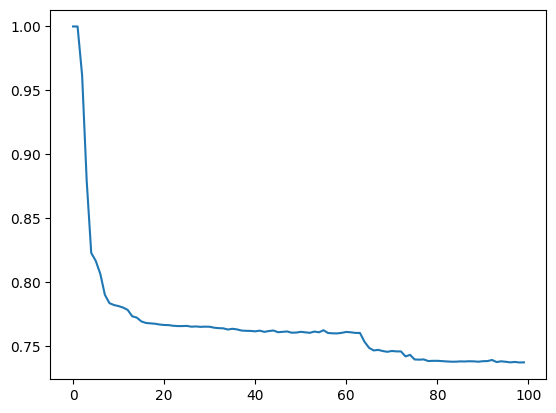

In [220]:
# Find reconstruction error
X_reconstructed = auto.reconstruct(X_train_latent)
reconstruction_error = np.mean((X_train - X_reconstructed)**2)
print("Reconstruction error:", reconstruction_error)

# plot the loss
import matplotlib.pyplot as plt
loss = auto.mlp.loss
plt.plot(loss)
plt.show()

In [221]:
# Get the latent representation of the data


print('Train size:', X_train_latent.shape, X_test_latent.shape)
# print(y_train[:10])

# knn classifier
from knn import KNNClassifier_P

knn = KNNClassifier_P(30, distance_metric='manhattan')
knn.fit(X_train_latent, y_train)
start_time = time.time()
y_pred = knn.predict(X_test_latent)
end_time = time.time()

from metrics import Metrics

metrics = Metrics(y_test, y_pred)

metrics.print_report()

print("Accuracy:", np.mean(y_test == y_pred))
print("Time:", end_time - start_time)

Train size: (90380, 6) (11400, 6)
Accuracy: 0.1254
Macro Precision: 0.1105
micro Precision: 0.1254
Macro Recall: 0.1266
Micro Recall: 0.1254
Macro F1 Score: 0.1094
Micro F1 Score: 0.1254
Specificity: 0.9923
Accuracy: 0.12535087719298246
Time: 22.79715061187744


In [222]:
# knn classifier
from knn import KNNClassifier_P

print(X_train.shape, y_train.shape)

knn = KNNClassifier_P(30, distance_metric='manhattan')
knn.fit(X_train, y_train)
start_time = time.time()
y_pred = knn.predict(X_test)
end_time = time.time()


from metrics import Metrics

metrics = Metrics(y_test, y_pred)

metrics.print_report()

print("Accuracy:", np.mean(y_test == y_pred))
print("Time:", end_time - start_time)

(90380, 15) (90380,)
Accuracy: 0.2491
Macro Precision: 0.2383
micro Precision: 0.2491
Macro Recall: 0.2505
Micro Recall: 0.2491
Macro F1 Score: 0.2322
Micro F1 Score: 0.2491
Specificity: 0.9934
Accuracy: 0.24912280701754386
Time: 31.092090368270874


In [223]:
print((np.unique(y_train)))

y_train = y_train.reshape(-1,1)
y_validate = y_validate.reshape(-1,1)

# train the mlp model
mlp = MLP(input_size=X_train.shape[1], hidden_layers=[24,48], output_size=len(np.unique(y_train))+1, epochs=100, learning_rate=0.1, 
          batch_size=32, activation_function='sigmoid', loss_function='cross_entropy', optimizer='mini_batch', beta=0.9, Random_state=None, 
          weight_init='he', model_type='class_MC', wandb_vaar=False, run_start="autoencoder_training", wandb_finish=False)

# train the model
mlp.fit(X_train, y_train, X_validate, y_validate)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113]
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55

(11400, 114)


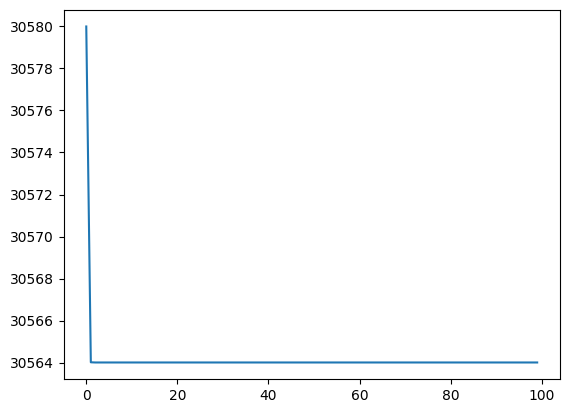

In [229]:
# predict
y_pred = mlp.predict(X_test)

print(y_pred.shape)

# plot loss
import matplotlib.pyplot as plt
plt.plot(mlp.loss)
plt.show()

In [228]:
y_pred_solved = np.argmax(y_pred, axis=1)

# save top 5 predictions
y_pred_top5 = np.argsort(y_pred, axis=1)[:,-10:]

# if the true label is in the top 5 predictions
top5 = np.zeros_like(y_test)
new_y_pred = np.zeros_like(y_test)
for i in range(len(y_test)):
    if y_test[i] in y_pred_top5[i]:
        top5[i] = 1
        new_y_pred[i] = y_test[i]

print("Top 5 accuracy:", np.mean(top5))

print(np.unique(y_pred_solved))

metrics = Metrics(y_test, new_y_pred)

metrics.print_report()

Top 5 accuracy: 0.08578947368421053
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113]
Accuracy: 0.0942
Macro Precision: 0.9825
micro Precision: 0.0942
Macro Recall: 0.0936
Micro Recall: 0.0942
Macro F1 Score: 0.1524
Micro F1 Score: 0.0942
Specificity: 0.9920
